In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras import regularizers
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Tidying up data
1) Removed features that are unrelated to the card prices, such as the number and id.
2) Removed features that are repeated (such as pend_desc and monster_desc, both of which are already included in desc, also type, which overlaps with frameType.
3) Dropped some rows with missing information, such as some rows from card_sets.
4) filled empty cells with 0, as all the values are intentionally missing due to the properties of the cards (e.g. Spell and Trap cards do not have Attack and Defence points).
5) split up nested cells into multiple columns, such as card_sets and card_prices, which contain multivariate features but are shown in only 1 single cell.

In [59]:
import ast
import os

import os
card_df=pd.read_csv('card_data.csv')

#drop all empty card sets
card_df=card_df.dropna(subset='card_sets')
# card_df = card_df.sample(n=2000), random_state=42)

# Remove descriptions for Normal monsters
card_df['desc']=[str(card_df['desc'].iloc[x]) if (card_df['type'].iloc[x]!='Normal Monster') else '' for x in range(len(card_df)) ]
card_df['cardlength']=[len(word_tokenize(x.translate(str.maketrans('', '', string.punctuation)))) for x in card_df['desc']]

#seperate card sets into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_sets'].values]
card_df['reprints']=[len(temp[x]) for x in range(len(temp))]
card_df['set_name']=[temp[x][0]['set_name'] for x in range(len(temp))]
card_df['set_rarity']=[temp[x][0]['set_rarity'] for x in range(len(temp))]
card_df['set_rarity_code']=[temp[x][0]['set_rarity_code'] for x in range(len(temp))]
card_df['set_price']=[temp[x][0]['set_price'] for x in range(len(temp))]
card_df=card_df.drop(['card_sets'],axis=1)

#seperate card images into individual columns
card_images=[ast.literal_eval(x) for x in card_df['card_images'].values]
image_url=[card_images[x][0]['image_url'] for x in range(len(card_images))]
image_url_small=[card_images[x][0]['image_url_small'] for x in range(len(card_images))]
image_url_cropped=[card_images[x][0]['image_url_cropped'] for x in range(len(card_images))]

#obtain images through the urls obtained
# dispimages=[Image.open(BytesIO(requests.get(x).content)) for x in image_url]
# card_df['card_images']=dispimages

#seperate card prices into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_prices'].values]
card_df['cardmarket_price']=[float(temp[x][0]['cardmarket_price']) for x in range(len(temp))]
card_df['tcgplayer_price']=[float(temp[x][0]['tcgplayer_price']) for x in range(len(temp))]
card_df['ebay_price']=[float(temp[x][0]['ebay_price']) for x in range(len(temp))]
card_df['amazon_price']=[float(temp[x][0]['amazon_price']) for x in range(len(temp))]
card_df['coolstuffinc_price']=[float(temp[x][0]['coolstuffinc_price']) for x in range(len(temp))]
card_df=card_df.drop(['card_prices'],axis=1)

#drop unwanted columns
carddesc=card_df['desc']
card_df=card_df.drop(['card_images'],axis=1)
card_df=card_df.drop(['Unnamed: 0','id','frameType','pend_desc','monster_desc','desc','set_rarity_code','linkmarkers'],axis=1)

card_df=card_df.fillna(-1)

card_df.head(5)

name        type        race     archetype  atk  \
0       "A" Cell Breeding Device  Spell Card  Continuous         Alien -1.0   
1             "A" Cell Incubator  Spell Card  Continuous         Alien -1.0   
2  "A" Cell Recombination Device  Spell Card  Quick-Play         Alien -1.0   
3         "A" Cell Scatter Burst  Spell Card  Quick-Play         Alien -1.0   
4     "Infernoble Arms - Almace"  Spell Card       Equip  Noble Knight -1.0   

   def  level attribute  scale  linkval  ... cardlength  reprints  \
0 -1.0   -1.0        -1   -1.0     -1.0  ...         16         1   
1 -1.0   -1.0        -1   -1.0     -1.0  ...         32         1   
2 -1.0   -1.0        -1   -1.0     -1.0  ...         66         1   
3 -1.0   -1.0        -1   -1.0     -1.0  ...         22         1   
4 -1.0   -1.0        -1   -1.0     -1.0  ...         89         2   

               set_name                   set_rarity set_price  \
0  Force of the Breaker                       Common      1.31   
1   Gladiator's Assault                       Common       2.1   
2   Invasion: Vengeance                       Common      1.12   
3        Strike of Neos                       Common      1.13   
4         Duelist Nexus  Quarter Century Secret Rare         0   

  cardmarket_price  tcgplayer_price  ebay_price  amazon_price  \
0             0.10             0.19        0.99         24.45   
1             0.07             0.24        1.25          0.50   
2             0.10             0.20        0.99          0.50   
3             0.12             0.10        2.00          9.76   
4             0.00             0.64        0.00          0.00   

   coolstuffinc_price  
0                0.25  
1                0.25  
2                0.49  
3                0.25  
4                0.00  

[5 rows x 21 columns]

In [51]:
card_df_val=card_df
# card_df_val=card_df_val.drop(['linkval'],axis=1)
dict_type=dict(enumerate(card_df.type.astype('category').cat.categories))
card_df_val.type=card_df_val.type.astype('category').cat.codes

card_df_val.race=card_df_val.race.astype('category').cat.codes
dict_race=dict(enumerate(card_df.race.astype('category').cat.categories))
card_df_val.archetype=card_df_val.archetype.astype('category').cat.codes
dict_archetype=dict(enumerate(card_df.archetype.astype('category').cat.categories))
card_df_val.banlist_info=card_df_val.banlist_info.astype('category').cat.codes
dict_banlist_info=dict(enumerate(card_df.banlist_info.astype('category').cat.categories))
card_df_val.attribute=card_df_val.attribute.astype('category').cat.codes
dict_attribute=dict(enumerate(card_df.attribute.astype('category').cat.categories))
card_df_val.set_name=card_df_val.set_name.astype('category').cat.codes
dict_set_name=dict(enumerate(card_df.set_name.astype('category').cat.categories))
card_df_val.set_rarity=card_df_val.sort_values(by=['set_rarity']).set_rarity.astype('category').cat.codes

card_df.head(5)
# print(card_df_val.coef_)
# card_df_val['set_price']

name  type  race  archetype  atk  def  level  \
0       "A" Cell Breeding Device    16    18         14 -1.0 -1.0   -1.0   
1             "A" Cell Incubator    16    18         14 -1.0 -1.0   -1.0   
2  "A" Cell Recombination Device    16    59         14 -1.0 -1.0   -1.0   
3         "A" Cell Scatter Burst    16    59         14 -1.0 -1.0   -1.0   
4     "Infernoble Arms - Almace"    16    28        318 -1.0 -1.0   -1.0   

   attribute  scale  linkval  ...  cardlength  reprints  set_name  set_rarity  \
0          0   -1.0     -1.0  ...          16         1       195           2   
1          0   -1.0     -1.0  ...          32         1       206           2   
2          0   -1.0     -1.0  ...          66         1       217           2   
3          0   -1.0     -1.0  ...          22         1       403           2   
4          0   -1.0     -1.0  ...          89         2       160          19   

   set_price cardmarket_price  tcgplayer_price  ebay_price  amazon_price  \
0       1.31             0.10             0.19        0.99         24.45   
1        2.1             0.07             0.24        1.25          0.50   
2       1.12             0.10             0.20        0.99          0.50   
3       1.13             0.12             0.10        2.00          9.76   
4          0             0.00             0.64        0.00          0.00   

   coolstuffinc_price  
0                0.25  
1                0.25  
2                0.49  
3                0.25  
4                0.00  

[5 rows x 21 columns]

In [133]:
card_df_val.describe()

type          race     archetype           atk           def  \
count  12374.000000  12374.000000  12374.000000  12374.000000  12374.000000   
mean      10.200016     44.891789    144.009940    964.165751    773.558752   
std        9.778390     20.822593    162.484927   1043.938384    916.687875   
min        0.000000      0.000000      0.000000     -1.000000     -1.000000   
25%        0.000000     28.000000      0.000000     -1.000000     -1.000000   
50%        8.000000     52.000000     73.000000    700.000000    300.000000   
75%       18.000000     59.000000    280.000000   1800.000000   1500.000000   
max       27.000000     85.000000    494.000000   5000.000000   5000.000000   

              level     attribute        scale       linkval  banlist_info  \
count  12374.000000  12374.000000  12374.00000  12374.000000  12374.000000   
mean       2.445531      2.338209     -0.85615     -0.894941      0.276144   
std        3.312697      2.374662      0.99680      0.613398      2.103662   
min       -1.000000      0.000000     -1.00000     -1.000000      0.000000   
25%       -1.000000      0.000000     -1.00000     -1.000000      0.000000   
50%        3.000000      1.000000     -1.00000     -1.000000      0.000000   
75%        4.000000      5.000000     -1.00000     -1.000000      0.000000   
max       13.000000      7.000000     13.00000      6.000000     25.000000   

         cardlength      reprints      set_name    set_rarity  tcgplayer_price  
count  12374.000000  12374.000000  12374.000000  12374.000000     12374.000000  
mean      51.829804      2.877323    147.767739     13.642638         1.206034  
std       28.909722      2.926368    127.718991     11.739748        18.758122  
min        0.000000      1.000000      0.000000      0.000000         0.000000  
25%       28.000000      1.000000     30.000000      2.000000         0.130000  
50%       50.000000      2.000000    116.000000     16.000000         0.200000  
75%       75.000000      3.000000    232.000000     27.000000         0.400000  
max      237.000000     61.000000    484.000000     31.000000       999.990000

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>, <Axes: >, <Axes: >]],
      dtype=object)

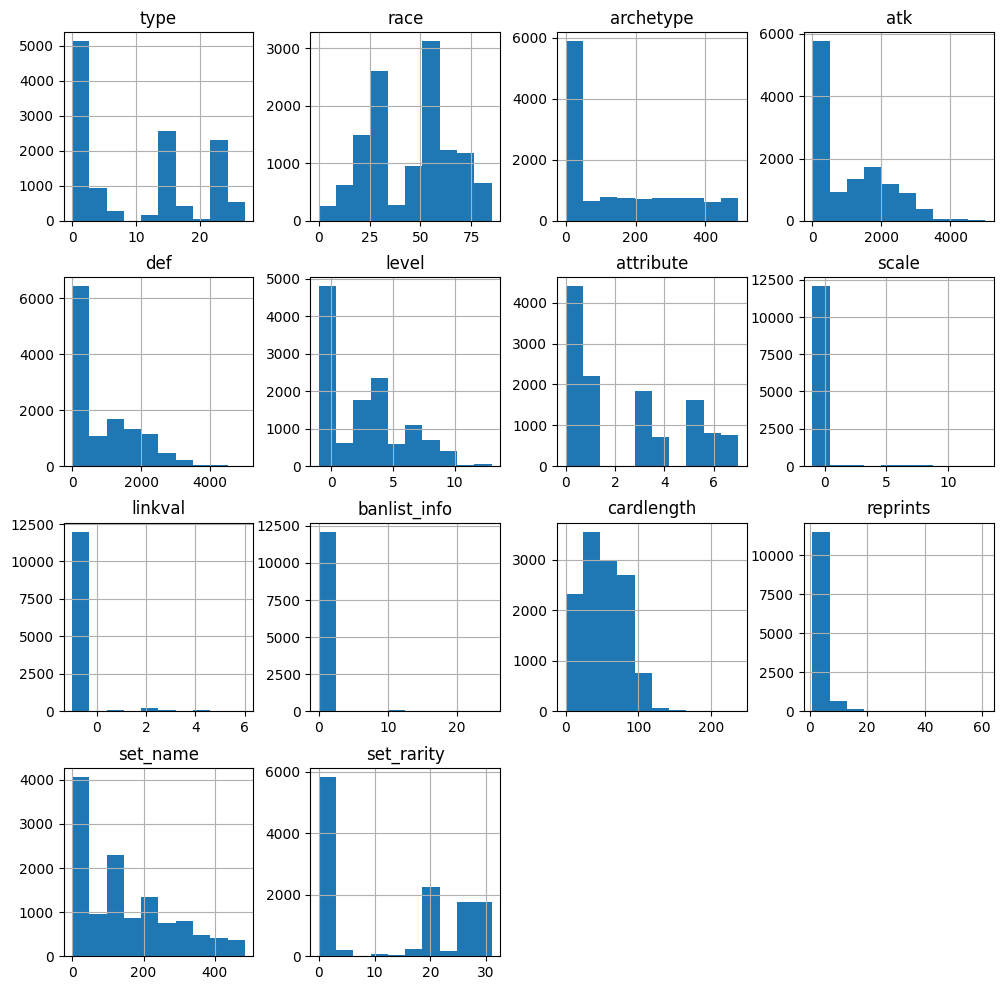

In [134]:
card_df_val.iloc[:,0:16].hist(figsize=(12,12),bins=10)

array([[<Axes: title={'center': 'cardmarket_price'}>,
        <Axes: title={'center': 'tcgplayer_price'}>],
       [<Axes: title={'center': 'ebay_price'}>,
        <Axes: title={'center': 'amazon_price'}>],
       [<Axes: title={'center': 'coolstuffinc_price'}>, <Axes: >]],
      dtype=object)

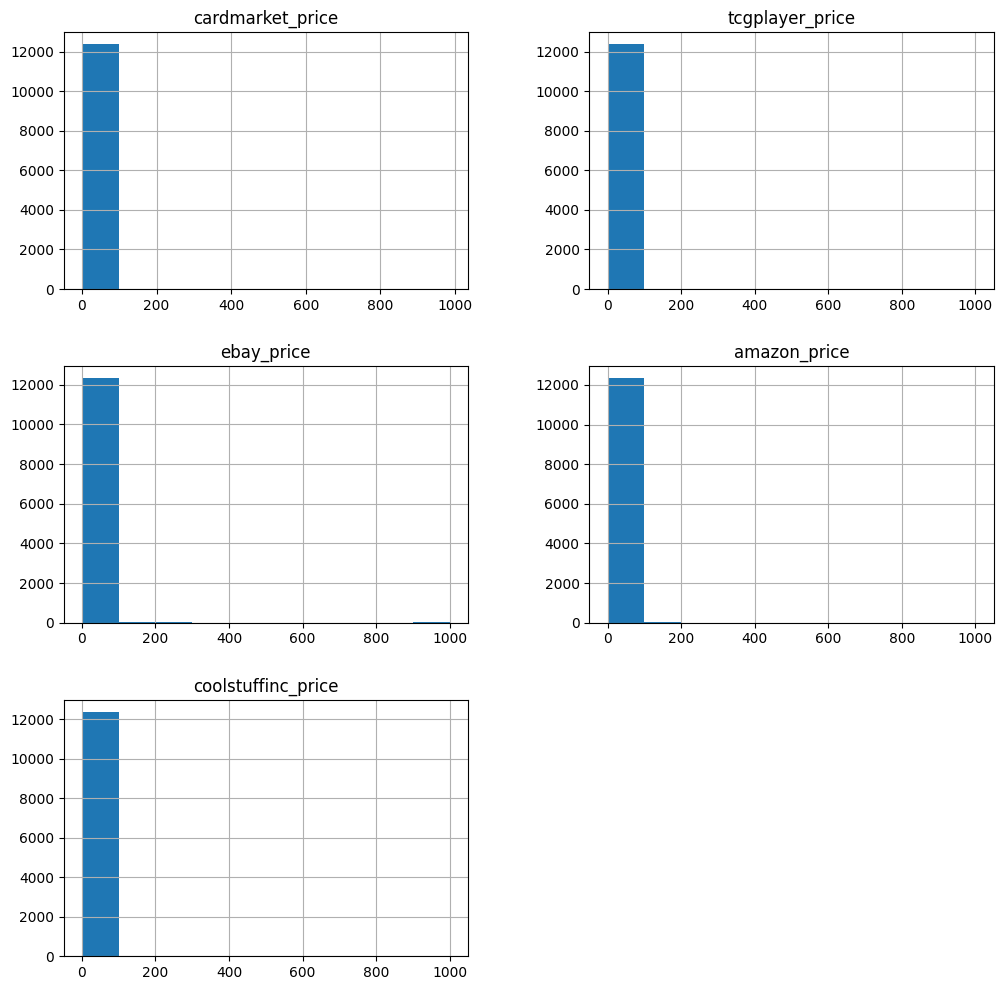

In [54]:
card_df_val.iloc[:,16:].hist(figsize=(12,12),bins=10)

In [55]:
card_df_val=card_df_val.drop(['cardmarket_price','ebay_price','amazon_price','coolstuffinc_price'],axis=1)

# Removing outliers

In [57]:
carddesc.shape

(12374,)

In [61]:
topquantile=card_df_val.tcgplayer_price.quantile(0.99)
print('Top Quantile is: {}'.format(topquantile))

card_df_val_final=card_df_val[card_df_val.tcgplayer_price>0]
card_df_val_final=card_df_val[card_df_val.tcgplayer_price<topquantile]
carddesc_final=carddesc[card_df_val.tcgplayer_price>0]
carddesc_final=carddesc[card_df_val.tcgplayer_price<topquantile]

card_df_val_final.describe()

Top Quantile is: 13.351600000000035
(12250, 17)
(12250,)


type          race     archetype           atk           def  \
count  12250.000000  12250.000000  12250.000000  12250.000000  12250.000000   
mean      10.203510     44.872245    144.190122    961.597878    771.102694   
std        9.789188     20.822419    162.487810   1042.490957    914.842775   
min        0.000000      0.000000      0.000000     -1.000000     -1.000000   
25%        0.000000     28.000000      0.000000     -1.000000     -1.000000   
50%        8.000000     49.500000     74.000000    600.000000    300.000000   
75%       18.000000     59.000000    280.000000   1800.000000   1500.000000   
max       27.000000     85.000000    494.000000   5000.000000   5000.000000   

              level     attribute         scale       linkval  banlist_info  \
count  12250.000000  12250.000000  12250.000000  12250.000000  12250.000000   
mean       2.435429      2.336980     -0.854857     -0.895347      0.270612   
std        3.304349      2.375016      1.001588      0.611870      2.096962   
min       -1.000000      0.000000     -1.000000     -1.000000      0.000000   
25%       -1.000000      0.000000     -1.000000     -1.000000      0.000000   
50%        3.000000      1.000000     -1.000000     -1.000000      0.000000   
75%        4.000000      5.000000     -1.000000     -1.000000      0.000000   
max       13.000000      7.000000     13.000000      6.000000     25.000000   

         cardlength      reprints      set_name    set_rarity  tcgplayer_price  
count  12250.000000  12250.000000  12250.000000  12250.000000     12250.000000  
mean      51.803102      2.886857    146.970776     13.566776         0.536979  
std       28.814038      2.936690    126.917306     11.744219         1.225402  
min        0.000000      1.000000      0.000000      1.000000         0.000000  
25%       28.000000      1.000000     30.000000      2.000000         0.120000  
50%       50.000000      2.000000    116.000000     13.000000         0.200000  
75%       75.000000      3.000000    230.000000     27.000000         0.390000  
max      237.000000     61.000000    484.000000     31.000000        13.330000

# Standardization

In [62]:
#Standardisation
np.random.seed(42)
scaler = StandardScaler()
columns=card_df.iloc[:,1:16].columns
X=card_df_val_final.iloc[:,1:16].to_numpy()
y=card_df_val_final.iloc[:,16].to_numpy()
X=np.double(X)
y=np.double(y)
# y=np.average(np.double(y),axis=1)
# print(y[0])

X_scaled=X

# X_scaled = scaler.fit_transform(X)
# # print(X.shape)
# X_df=pd.DataFrame(X_scaled,columns=columns)
# X_df.hist(figsize=(12,12))
# X_scaled[0]
# card_df_val.head

# Correlation Chart

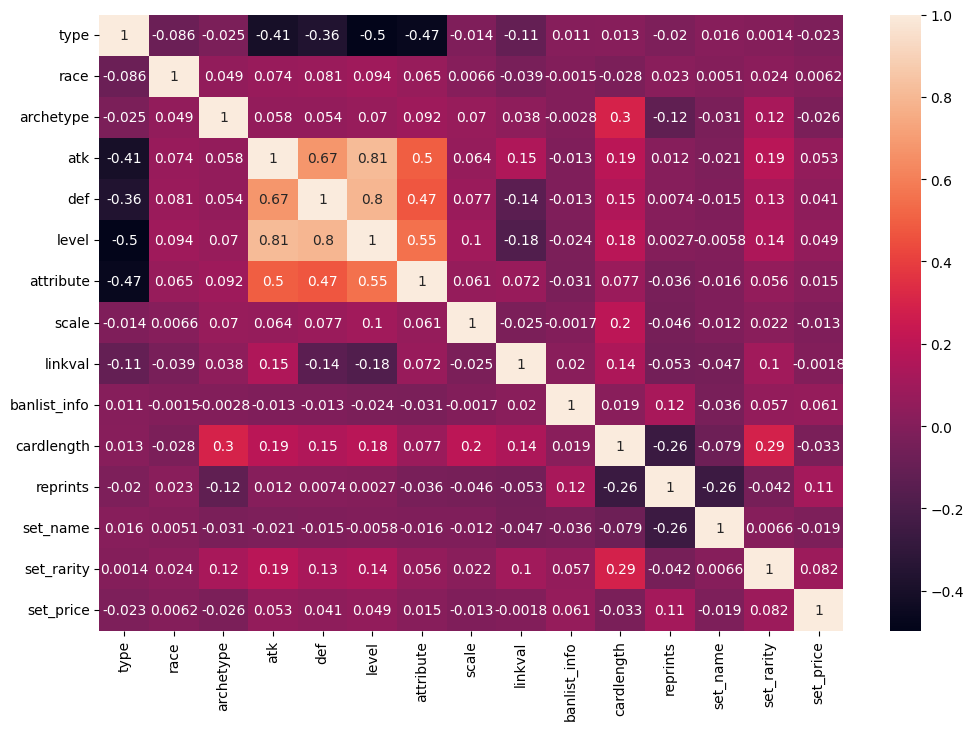

In [10]:
plt.figure(figsize=(12,8))
card_cor = card_df_val_final.iloc[:,1:16].corr()
sns.heatmap(card_cor, annot=True)
plt.show()

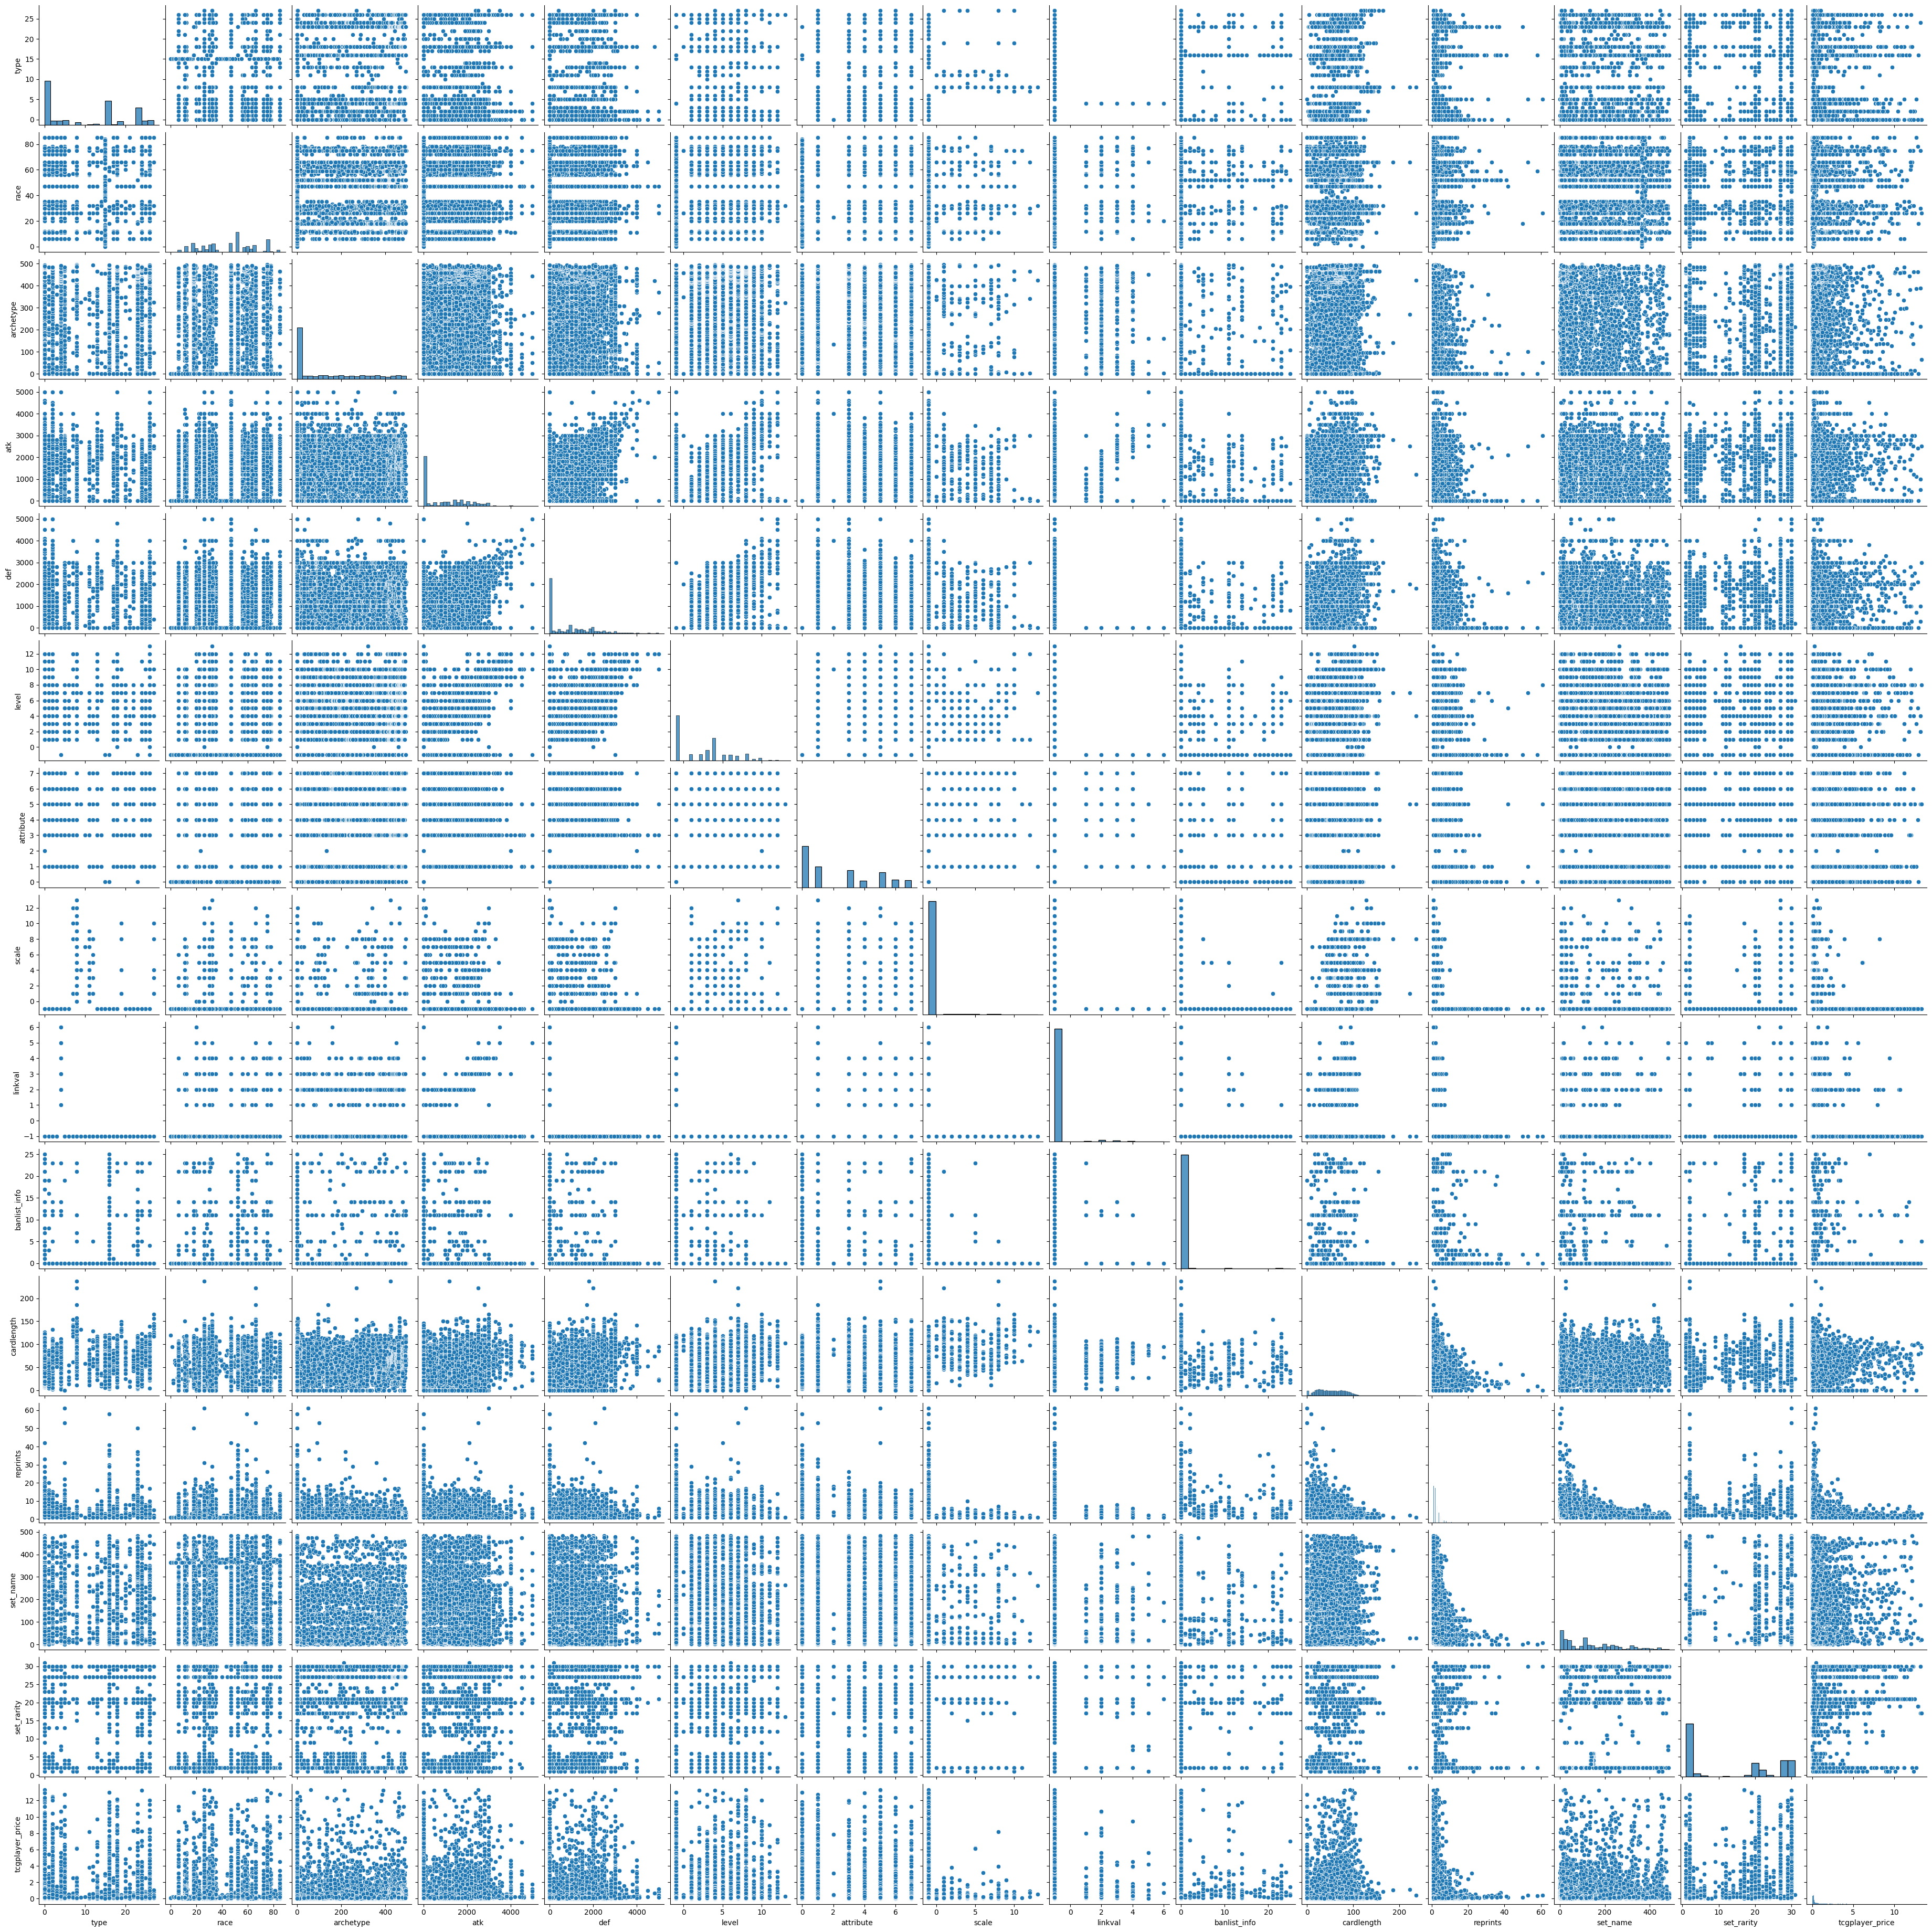

In [11]:
sns.pairplot(card_df_val_final)

# NLP

In [124]:
from nltk import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

max_length=0

method_bow=CountVectorizer(stop_words='english')
method_tfidf = TfidfVectorizer(stop_words='english', max_features=888)
for ind,x in enumerate(carddesc_final):
    lemmatized_array=[]
    tokens=word_tokenize(x.lower().translate(str.maketrans('', '', string.punctuation)))
    for singular_token in tokens:
        lemmatized=(lemmatizer.lemmatize(singular_token))
        if(lemmatized_array!=[]):
            if(lemmatized in lemmatized_array):
                lemmatized_array.append(lemmatized)
        else:
            lemmatized_array.append(lemmatized)
            
    if(max_length<len(lemmatized_array)):
        print(lemmatized_array)
        max_length=len(lemmatized_array)
        # print(tokens)

print('Maximum card length is: {}'.format(max_length))

carddesc_bow=method_bow.fit_transform(carddesc_final).toarray()
# print(carddesc_bow[:5])
vocabs=len(method_bow.vocabulary_)
print('Max Vocabulary Available= {}'.format(vocabs))
carddesc_onehot = [one_hot(x, vocabs) for x in carddesc_final]


carddesc_tfidf=method_tfidf.fit_transform(carddesc_final).toarray()
print('Max Vocabulary Available= {}'.format(carddesc_tfidf.shape[1]))

print(method_tfidf.vocabulary_)

#padding so that the dimensions align
carddesc_padded = pad_sequences(carddesc_onehot, maxlen=max_length, padding='post')

['during']
['when', 'when']
['if', 'if', 'if']
['monster', 'monster', 'monster', 'monster']
['fusion', 'fusion', 'fusion', 'fusion', 'fusion']
['this', 'this', 'this', 'this', 'this', 'this']
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']
['this', 'this', 'this', 'this', 'this', 'this', 'this', 'this', 'this']
['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
Maximum card length is: 10
Max Vocabulary Available= 6292
Max Vocabulary Available= 888
{'standby': 738, 'phases': 573, 'counter': 171, 'face': 284, 'monster': 515, 'opponent': 551, 'controls': 168, 'time': 792, 'removed': 632, 'play': 581, 'card': 128, 'effect': 256, 'place': 578, 'destroyed': 207, 'counters': 172, 'monsters': 516, 'target': 778, 'field': 289, 'send': 689, 'alien': 47, 'deck': 191, 'graveyard': 353, 'equal': 266, 'level': 444, 'sent': 692, 'main': 479, 'phase': 572, 'turn': 818, 'banish': 87, 'add': 36, 'hand': 369, 'select': 685, 'control': 165, 'destroy': 206, 'new': 537, 'equippe

In [125]:
seed=42
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp=train_test_split(carddesc_tfidf,y, test_size=0.20, random_state=seed, shuffle=True)
X_test_nlp,X_valid_nlp,y_test_nlp,y_valid_nlp=train_test_split(X_test_nlp,y_test_nlp,test_size=0.50,random_state=seed, shuffle=True)

# SVR NLP

In [126]:
svm_model_nlp = SVR(C=20).fit(X_train_nlp, y_train_nlp)

ypred_svr_nlp = svm_model_nlp.predict(X_test_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
# print('coefficient of determination for testing phase', svm_model_nlp.score(X_test_nlp,y_test_nlp))
comparision_df_svr_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_svr_nlp})

print('R2 testing:', metrics.r2_score(y_test_nlp,ypred_svr_nlp))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test_nlp, ypred_svr_nlp)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid_nlp = svm_model_nlp.predict(X_valid_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('R2 valid:', metrics.r2_score(y_valid_nlp,ypred_svr_valid_nlp))
# print('coefficient of determination for validation phase', svm_model_nlp.score(X_valid_nlp,y_valid_nlp))
comparision_df_svr_valid_nlp=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_svr_valid_nlp})


print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid_nlp, ypred_svr_valid_nlp)))

R2 testing: -0.008470922510315892
RMSE testing: 1.3489267329462906
R2 valid: -0.08897766155914688
RMSE validation: 1.1790483396649685


<Axes: ylabel='Frequency'>

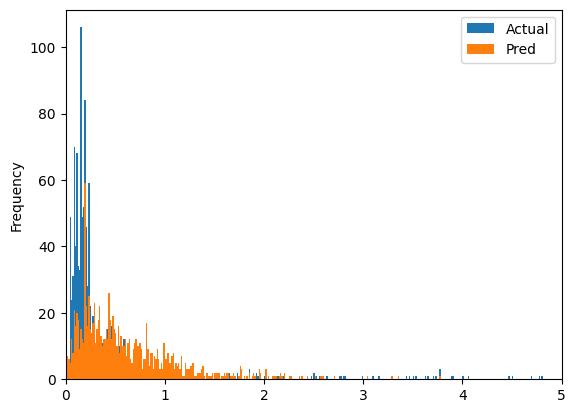

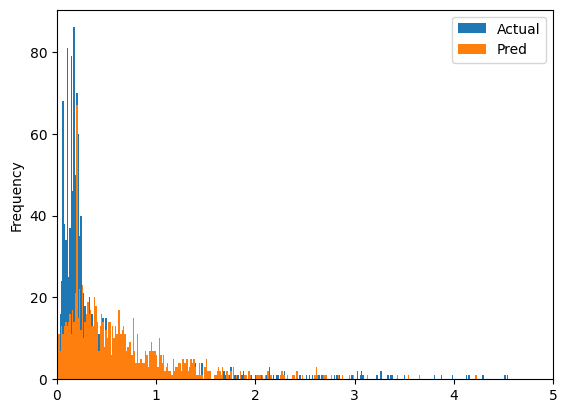

In [127]:
comparision_df_svr_nlp.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_svr_valid_nlp.plot(kind='hist',bins=1000,xlim=(0,5))

In [128]:
# def scheduler(epoch, lr):
#     if epoch % 100:
#         return lr
#     else:
#         return lr * 0.1

# callback = keras.callbacks.LearningRateScheduler(scheduler)
D1=16
D2=16
D3=8
lr=1e-4

my_nn_nlp=Sequential()
my_nn_nlp.add(Dense(D1,input_dim=X_train_nlp.shape[1]))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(D2,input_dim=D1,activation='relu'))
# my_nn_nlp.add(Dropout(0.2))
my_nn_nlp.add(Dense(D3,input_dim=D2,activation='relu'))
# my_nn_nlp.add(Dropout(0.2))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(1,input_dim=D3)) #Output shape is 1 because we're doing regression
print(my_nn_nlp.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn_nlp.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
my_nn_nlp.fit(X_train_nlp,y_train_nlp,verbose=1,epochs=100, validation_data=(X_test_nlp,y_test_nlp))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 16)                14224     
                                                                 
 batch_normalization_31 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                                 
 dense_43 (Dense)            (None, 16)                272       
                                                                 
 dense_44 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization_32 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 1)               

In [129]:
y_pred_nn_nlp_train = my_nn_nlp.predict(X_train_nlp)
y_pred_nn_nlp_true_train = y_pred_nn_nlp_train[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_train_nlp,y_pred_nn_nlp_true_train)
print("Final score (R2): {}".format(metrics.r2_score(y_train_nlp,y_pred_nn_nlp_true_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train_nlp,y_pred_nn_nlp_true_train))))

comparision_df_nn_nlp_train=pd.DataFrame({'Actual':y_train_nlp,'Pred':y_pred_nn_nlp_true_train})
comparision_df_nn_nlp_train.head()

307/307 [==============================] - 0s 801us/step
Final score (R2): 0.6802588914541736
Final score (RMSE): 0.6905921302086275


Actual      Pred
0    2.78  2.049814
1    0.07  0.244445
2    0.20  0.326952
3    0.35  1.412431
4    0.33 -0.042799

In [130]:
y_pred_nn_nlp = my_nn_nlp.predict(X_test_nlp)
y_pred_nn_nlp_true = y_pred_nn_nlp[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,y_pred_nn_nlp_true))))
# print(y_pred_nn_nlp_true.shape)
# print(y_test_nlp.shape)
comparision_df_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':y_pred_nn_nlp_true})
comparision_df_nn_nlp.head()

y_pred_nn_nlp_valid = my_nn_nlp.predict(X_valid_nlp)
y_pred_nn_nlp_valid = y_pred_nn_nlp_valid[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_valid_nlp,y_pred_nn_nlp_valid)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,y_pred_nn_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,y_pred_nn_nlp_valid))))
# print(y_pred_nn_nlp_true.shape)
# print(y_test_nlp.shape)
comparision_df_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':y_pred_nn_nlp_valid})
comparision_df_nn_nlp_valid.head()

39/39 [==============================] - 0s 978us/step
Final score (R2): -0.29250827938593615
Final score (RMSE): 1.5271206089748892
(1225,)
(1225,)
39/39 [==============================] - 0s 1ms/step
Final score (R2): -0.6405348233113375
Final score (RMSE): 1.4471543429127056


Actual      Pred
0    2.85  1.680079
1    0.08  0.635135
2    3.34  0.636296
3    0.11  0.845769
4    0.09  0.142043

# Random Forest for NLP

In [131]:
rf_nlp=RandomForestRegressor(n_estimators=50)
rf_nlp.fit(X_train_nlp,y_train_nlp)
ypred_rf_nlp=rf_nlp.predict(X_test_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,ypred_rf_nlp)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,ypred_rf_nlp))))
# print(ypred_rf_nlp.shape)
# print(y_test_nlp.shape)
comparision_df_rf_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_rf_nlp})
comparision_df_rf_nn_nlp.head()

ypred_rf_nlp_valid=rf_nlp.predict(X_valid_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,ypred_rf_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,ypred_rf_nlp_valid))))
comparision_df_rf_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_rf_nlp_valid})
comparision_df_rf_nn_nlp_valid.head()

Final score (R2): -0.06468707765687798
Final score (RMSE): 1.3860141458156858
Final score (R2): -0.11673274593561977
Final score (RMSE): 1.1939791723803066


Actual      Pred
0    2.85  0.798200
1    0.08  0.702400
2    3.34  0.702478
3    0.11  0.367400
4    0.09  0.819281

# Gradient Boosting for NLP

In [132]:
gb_nlp = GradientBoostingRegressor(random_state=42)
gb_nlp.fit(X_train_nlp,y_train_nlp)

ypred_gb_nlp=gb_nlp.predict(X_test_nlp)

print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,ypred_gb_nlp)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,ypred_gb_nlp))))
# print(ypred_rf_nlp.shape)
# print(y_test_nlp.shape)
comparision_df_gb_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_gb_nlp})
comparision_df_gb_nn_nlp.head()

ypred_gb_nlp_valid=gb_nlp.predict(X_valid_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,ypred_gb_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,ypred_gb_nlp_valid))))
comparision_df_gb_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_gb_nlp_valid})
comparision_df_gb_nn_nlp_valid.head()

Final score (R2): -0.008137945335953356
Final score (RMSE): 1.3487040200826161
Final score (R2): -0.02758263811645212
Final score (RMSE): 1.145329651811685


Actual      Pred
0    2.85  0.426150
1    0.08  0.431567
2    3.34  0.450950
3    0.11  0.450950
4    0.09  0.460527

## Random Forest Regressor

<BarContainer object of 15 artists>

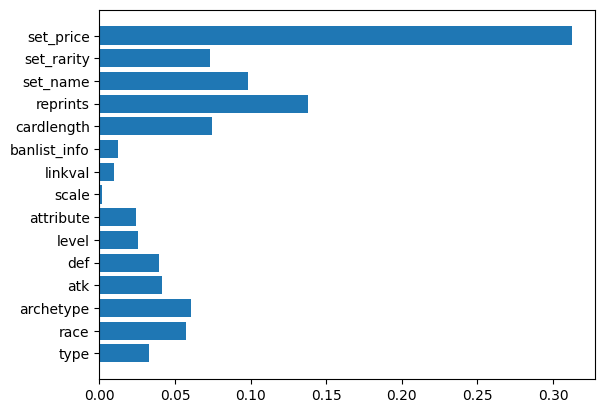

In [23]:
forestreg=RandomForestRegressor(n_estimators=50,random_state=42)
forestreg.fit(X,y)

gamma=forestreg.feature_importances_
plt.barh(columns,gamma)

# Feature Selection

In [24]:
#Remove unwanted features
X_filtered=X[:,gamma>0.06]
columns_filtered=columns[gamma>0.06]
print('number of columns after feature selection is: {}'.format(len(columns_filtered)))
print('columns picked are: {}'.format(columns_filtered))

number of columns after feature selection is: 6
columns picked are: Index(['archetype', 'cardlength', 'reprints', 'set_name', 'set_rarity',
       'set_price'],
      dtype='object')


# Split train and test set

In [25]:
#split the dataset, random_state for replication
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.20, random_state=seed, shuffle=True) 
X_test,X_valid,y_test,y_valid=train_test_split(X_test,y_test,test_size=0.50,random_state=seed, shuffle=True)

# Linear Regression (BASELINE)

In [26]:
linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)
ypred_linreg=linreg_model.predict(X_test)
ypred_linreg_valid=linreg_model.predict(X_valid)
# print(features)
# print(columns)
# print(features.shape)


# Comparision (Linear Regression)

In [27]:
comparision_df_linreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_linreg})
comparision_df_linreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_linreg_valid})
print('R2 test:', np.sqrt(metrics.r2_score(y_test, ypred_linreg)))
print('RMSE test:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))

print('R2 valid:', np.sqrt(metrics.r2_score(y_valid, ypred_linreg_valid)))
print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_linreg_valid)))
comparision_df_linreg.head(25)

R2 test: 0.2869711685180528
RMSE test: 1.2867513294236665
R2 valid: 0.22499251326397499
RMSE valid: 1.1008845877368716


Actual      Pred
0     0.13  0.222943
1     0.47  0.254293
2     8.71  0.703478
3     0.16  0.479726
4     0.20  0.267896
5     0.25  0.841697
6     0.17  0.296165
7     0.17  0.284563
8     0.21  0.488150
9     0.92  1.052473
10    0.10  0.431783
11    0.17  0.418668
12    0.14  0.703075
13    1.08  1.159763
14    0.22  0.365130
15    0.21  0.578828
16    0.23  0.852748
17    0.17  0.439949
18    0.23  0.635244
19    0.25  0.172076
20    0.19  0.749759
21    0.19  0.230656
22    0.07  0.256864
23    0.10  0.057741
24    0.29  0.572377

RMSE: 1.2867513294236665


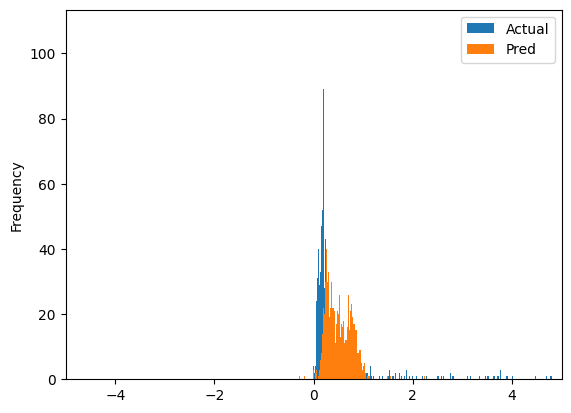

In [28]:
comparision_df_linreg.plot(kind='hist',bins=1000,xlim=(-5,5))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))
# comparision_df_linreg['Actual']

<BarContainer object of 6 artists>

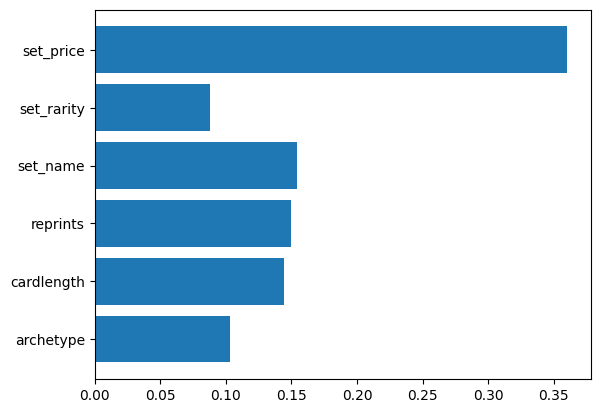

In [29]:
forestreg=RandomForestRegressor(n_estimators=100,random_state=seed)
forestreg.fit(X_filtered,y)

gamma=forestreg.feature_importances_
plt.barh(columns_filtered,gamma)

In [30]:
ypred_forestreg=forestreg.predict(X_test)
comparision_df_forestreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_forestreg})

print('R2 score:', metrics.r2_score(y_test, ypred_forestreg))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_test, ypred_forestreg)))
# comparision_df_forestreg.head(25)

ypred_forestreg_valid=forestreg.predict(X_valid)
comparision_df_forestreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_forestreg_valid})


print('R2 score:', metrics.r2_score(y_valid, ypred_forestreg_valid))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_forestreg_valid)))
comparision_df_forestreg_valid.head(25)

R2 score: 0.9246389655192029
RMSE score: 0.3687483595654568
R2 score: 0.8949718798498554
RMSE score: 0.3661633912369842


Actual      Pred
0     2.85  2.096800
1     0.08  0.128500
2     3.34  2.972324
3     0.11  0.190100
4     0.09  0.097000
5     0.17  0.201100
6     0.16  0.206000
7     0.23  0.253600
8     0.74  0.757900
9     0.19  0.163900
10    0.08  0.077200
11    0.99  1.392000
12    0.10  0.185933
13    0.49  0.500800
14    0.05  0.078533
15    0.19  0.187300
16    0.14  0.140700
17    0.22  0.261000
18    0.30  0.244000
19    0.56  0.557200
20    0.11  0.165100
21    0.23  0.220900
22    0.06  0.066700
23    0.19  0.206300
24    0.50  0.646800

<Axes: ylabel='Frequency'>

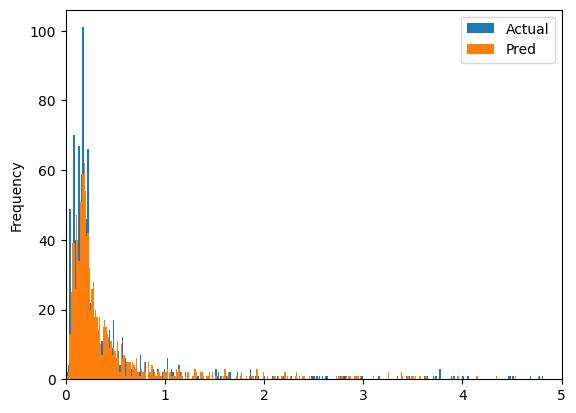

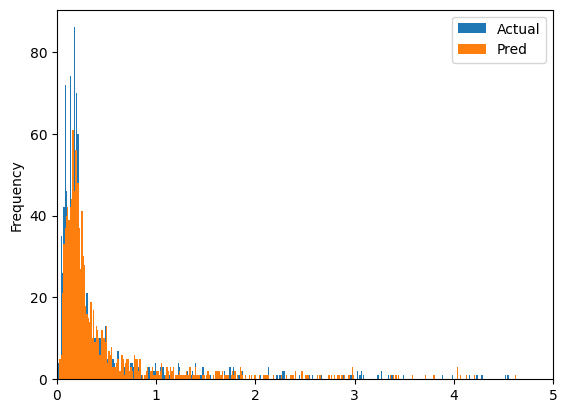

In [31]:
comparision_df_forestreg.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_forestreg_valid.plot(kind='hist',bins=1000,xlim=(0,5))
# comparision_df_linreg['Actual']

# Decision Tree

In [32]:
tree1 = DecisionTreeRegressor(max_depth=5, random_state=seed)
tree2 = DecisionTreeRegressor(max_depth=1, random_state=seed)
tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)

ypred_tree1=tree1.predict(X_test)
ypred_tree2=tree2.predict(X_test)

comparision_df_tree1=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree1})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree1)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree1))
comparision_df_tree2=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree2})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree2)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree2))

comparision_df_tree1.head(25)

RMSE: 1.0364920342933277
R2 score: 0.40458661283929365
RMSE: 1.2644402601628426
R2 score: 0.1138988741233582


Actual      Pred
0     0.13  0.125306
1     0.47  0.285637
2     8.71  8.550000
3     0.16  0.209804
4     0.20  0.429543
5     0.25  0.209804
6     0.17  1.780627
7     0.17  0.125306
8     0.21  0.209804
9     0.92  1.104151
10    0.10  0.125306
11    0.17  0.209804
12    0.14  0.209804
13    1.08  0.906195
14    0.22  0.125306
15    0.21  0.906195
16    0.23  0.209804
17    0.17  0.429543
18    0.23  0.411392
19    0.25  0.209804
20    0.19  0.591318
21    0.19  0.209804
22    0.07  0.125306
23    0.10  0.209804
24    0.29  1.813621

<Axes: ylabel='Frequency'>

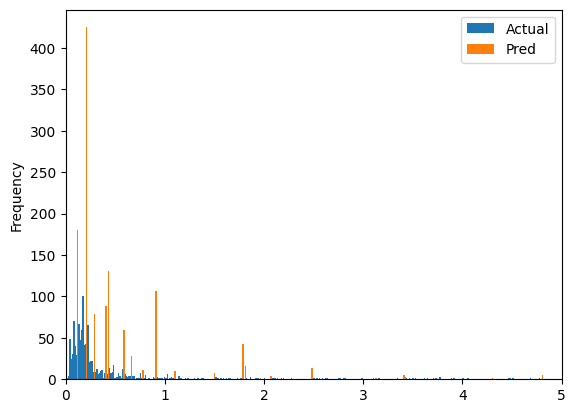

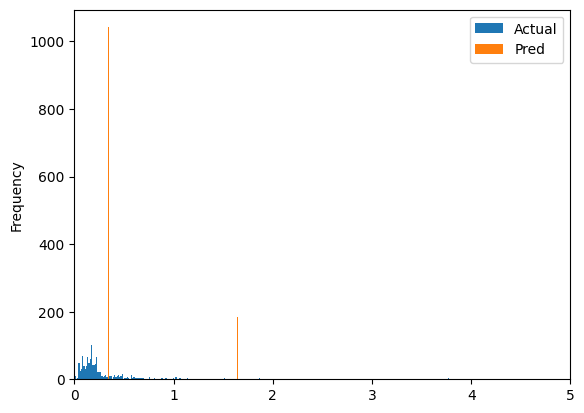

In [33]:
comparision_df_tree1.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_tree2.plot(kind='hist',bins=1000,xlim=(0,5))

# Gradient Boosting

In [34]:
gb = GradientBoostingRegressor(random_state=seed)
gb.fit(X_train,y_train)

ypred_gb=gb.predict(X_test)

comparision_df_gb=pd.DataFrame({'Actual':y_test,'Pred':ypred_gb})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_gb)))
print('R2 score:', metrics.r2_score(y_test, ypred_gb))

RMSE: 0.9763015293829336
R2 score: 0.4717316438770489


# SVR

In [35]:
svm_model = SVR(C=20).fit(X_train, y_train)

ypred_svr = svm_model.predict(X_test)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
comparision_df_svr=pd.DataFrame({'Actual':y_test,'Pred':ypred_svr})

print('R2 score:', metrics.r2_score(y_test, ypred_svr))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test, ypred_svr)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid = svm_model.predict(X_valid)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))

comparision_df_svr_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_svr_valid})

print('R2 score:', metrics.r2_score(y_valid, ypred_svr_valid))
print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_svr_valid)))

R2 score: 0.07872072308025757
RMSE testing: 1.2892950712608642
R2 score: 0.034210278749449596
RMSE validation: 1.1103589946554142


<Axes: ylabel='Frequency'>

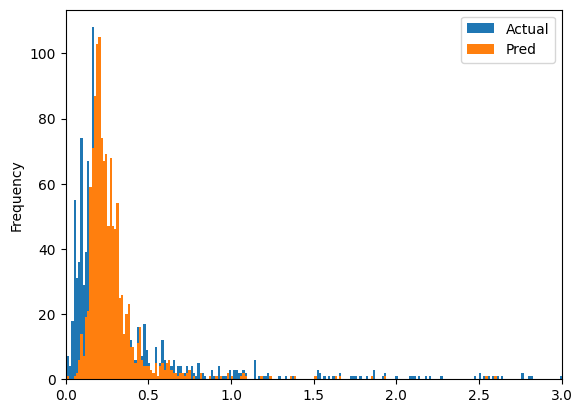

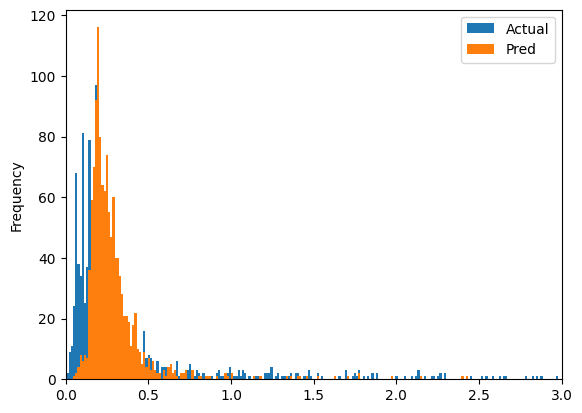

In [36]:
comparision_df_svr.plot(kind='hist',bins=1000,xlim=(0,3))
comparision_df_svr_valid.plot(kind='hist',bins=1000,xlim=(0,3))

# Neural Networks

In [98]:
# def scheduler(epoch, lr):
#     if epoch % 10:
#         return lr 
#     else:
#         return lr *0.90

# callback = keras.callbacks.LearningRateScheduler(scheduler)
epochs=800
D1=32
D2=16
D3=8
lr=1e-3
# D3=128
# D4=64
my_nn=Sequential()
my_nn.add(Dense(D1,input_dim=X_filtered.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
# my_nn.add(Dropout(0.4))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
# my_nn.add(Dropout(0.4))
my_nn.add(BatchNormalization())
my_nn.add(Dense(1,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu')) #Output shape is 1 because we're doing regression
# print(my_nn.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
my_nn.fit(X_train,y_train,verbose=1,batch_size=16,epochs=epochs, validation_data=(X_test,y_test))#, callbacks=[callback])

Epoch 1/800
613/613 [==============================] - 3s 2ms/step - loss: 1.5655 - mse: 1.5654 - val_loss: 1.7723 - val_mse: 1.7722
Epoch 2/800
613/613 [==============================] - 1s 1ms/step - loss: 1.4893 - mse: 1.4893 - val_loss: 1.7027 - val_mse: 1.7026
Epoch 3/800
613/613 [==============================] - 1s 1ms/step - loss: 1.4437 - mse: 1.4436 - val_loss: 1.6489 - val_mse: 1.6488
Epoch 4/800
613/613 [==============================] - 1s 1ms/step - loss: 1.4028 - mse: 1.4027 - val_loss: 1.7163 - val_mse: 1.7162
Epoch 5/800
613/613 [==============================] - 1s 1ms/step - loss: 1.3768 - mse: 1.3767 - val_loss: 1.7513 - val_mse: 1.7512
Epoch 6/800
613/613 [==============================] - 1s 1ms/step - loss: 1.3329 - mse: 1.3328 - val_loss: 1.7737 - val_mse: 1.7737
Epoch 7/800
613/613 [==============================] - 1s 1ms/step - loss: 1.2983 - mse: 1.2982 - val_loss: 1.7320 - val_mse: 1.7319
Epoch 8/800
613/613 [==============================] - 1s 1ms/step - 

In [99]:
my_nn.evaluate(X_train,y_train)
y_pred_nn = my_nn.predict(X_test)
y_pred_nn = y_pred_nn[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test,y_pred_nn)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_nn))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn=pd.DataFrame({'Actual':y_test,'Pred':y_pred_nn})
# comparision_df_nn[comparision_df_nn.Pred>0]

y_pred_nn_valid = my_nn.predict(X_valid)
y_pred_nn_valid = y_pred_nn_valid[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_valid,y_pred_nn_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid,y_pred_nn_valid))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn_valid=pd.DataFrame({'Actual':y_valid,'Pred':y_pred_nn_valid})
# comparision_df_nn_valid[comparision_df_nn_valid.Pred>0]

39/39 [==============================] - 0s 1ms/step
Final score (R2): 0.3926579494686899
Final score (RMSE): 1.0468232191331615
39/39 [==============================] - 0s 841us/step
Final score (R2): 0.20084886927556023
Final score (RMSE): 1.0100353751890818


In [100]:
y_pred_nn_train = my_nn.predict(X_train)
y_pred_nn_train = y_pred_nn_train[:,0]
print("Final score (R2): {}".format(metrics.r2_score(y_train,y_pred_nn_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_nn_train))))

307/307 [==============================] - 0s 785us/step
Final score (R2): 0.44401408674377507
Final score (RMSE): 0.9106558480436365


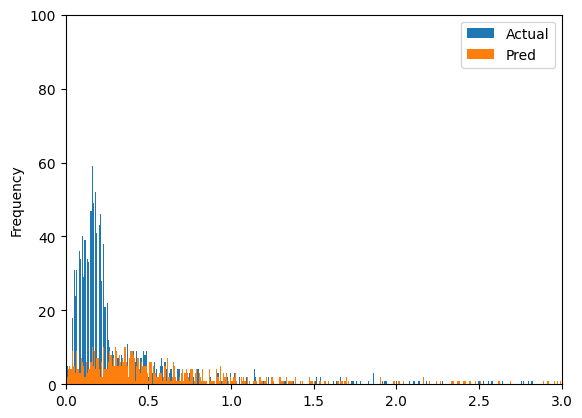

In [97]:
comparision_df_nn.plot(kind='hist',bins=2000,xlim=(0,3),ylim=(0,100))
plt.show()

# Optimizing hyperparameters to avoid overfitting

In [123]:
# def scheduler(epoch, lr):
#     if epoch % 10:
#         return lr 
#     else:
#         return lr *0.90

# callback = keras.callbacks.LearningRateScheduler(scheduler)
epochs=1000
D1=32
D2=16
D3=8
lr=1e-3
# D3=128
# D4=64
my_nn2=Sequential()
my_nn2.add(Dense(D1,input_dim=X_filtered.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-5),activation='relu'))
my_nn2.add(BatchNormalization())
my_nn2.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-5),activation='relu'))
my_nn.add(Dropout(0.2))
my_nn2.add(BatchNormalization())
my_nn2.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-5),activation='relu'))
my_nn.add(Dropout(0.2))
my_nn2.add(BatchNormalization())
my_nn2.add(Dense(1)) #Output shape is 1 because we're doing regression
# print(my_nn.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn2.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse'])
my_nn2.fit(X_train,y_train,verbose=1,batch_size=32,epochs=epochs, validation_data=(X_test,y_test))#, callbacks=[callback])

Epoch 1/1000
307/307 [==============================] - 2s 2ms/step - loss: 1.5228 - mse: 1.5223 - val_loss: 1.6565 - val_mse: 1.6561
Epoch 2/1000
307/307 [==============================] - 0s 1ms/step - loss: 1.3733 - mse: 1.3729 - val_loss: 1.6048 - val_mse: 1.6043
Epoch 3/1000
307/307 [==============================] - 0s 1ms/step - loss: 1.3399 - mse: 1.3395 - val_loss: 1.5864 - val_mse: 1.5859
Epoch 4/1000
307/307 [==============================] - 0s 1ms/step - loss: 1.2874 - mse: 1.2870 - val_loss: 1.5133 - val_mse: 1.5129
Epoch 5/1000
307/307 [==============================] - 0s 1ms/step - loss: 1.2268 - mse: 1.2263 - val_loss: 1.4001 - val_mse: 1.3996
Epoch 6/1000
307/307 [==============================] - 0s 1ms/step - loss: 1.2103 - mse: 1.2099 - val_loss: 1.4304 - val_mse: 1.4299
Epoch 7/1000
307/307 [==============================] - 1s 2ms/step - loss: 1.1847 - mse: 1.1842 - val_loss: 1.4201 - val_mse: 1.4196
Epoch 8/1000
307/307 [==============================] - 0s 2ms

In [121]:
y_pred_nn_train2 = my_nn2.predict(X_train)
print("Final score (R2): {}".format(metrics.r2_score(y_train,y_pred_nn_train2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_nn_train))))

307/307 [==============================] - 0s 855us/step
Final score (R2): 0.41959307105529553
Final score (RMSE): 0.9106558480436365


In [122]:
y_pred_nn2 = my_nn2.predict(X_test)
y_pred_nn2 = y_pred_nn2[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test,y_pred_nn2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_nn2))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn=pd.DataFrame({'Actual':y_test,'Pred':y_pred_nn2})
# comparision_df_nn[comparision_df_nn.Pred>0]

y_pred_nn_valid2 = my_nn2.predict(X_valid)
y_pred_nn_valid2 = y_pred_nn_valid2[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_valid,y_pred_nn_valid2)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid,y_pred_nn_valid2))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn_valid2=pd.DataFrame({'Actual':y_valid,'Pred':y_pred_nn_valid2})
# comparision_df_nn_valid[comparision_df_nn_valid.Pred>0]

39/39 [==============================] - 0s 1ms/step
Final score (R2): 0.37897296453419504
Final score (RMSE): 1.058551336305414
39/39 [==============================] - 0s 786us/step
Final score (R2): 0.20043187408738095
Final score (RMSE): 1.010298857868899


# Combining NLP and Numerical Features